# Data Preparation in Jupyter Notebook

In [ ]:
import pandas as pd
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from tqdm import tqdm

In [ ]:
# Load the metadata CSV
df = pd.read_csv("C:/Users/yingw/OneDrive/Documents/MSBA/BANA 274 Deep learning/HW2/data/fashion.csv")

# Keep only the two relevant categories: Apparel and Footwear
df = df[df["Category"].isin(["Apparel", "Footwear"])]

# Create binary labels: Apparel -> 0, Footwear -> 1
labels = df["Category"].apply(lambda x: 0 if x == "Apparel" else 1)

# Extract the image file names (these could later be joined with image folders if needed)
image_paths = df["Image"]  # Or use 'ImageURL' if 'Image' doesn't map to local files

# Split 20% of the data for testing
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Split the remaining 80% into 75% training and 25% cross-validation
X_train, X_cv, y_train, y_cv = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Print the sizes of each split
print("Training set size:", len(X_train))
print("Cross-validation set size:", len(X_cv))
print("Test set size:", len(X_test))

Training set size: 1743
Cross-validation set size: 581
Test set size: 582


### Define Where to Search for Images

In [ ]:
# All possible directories where images are stored
image_dirs = [
    "C:/Users/yingw/OneDrive/Documents/MSBA/BANA 274 Deep learning/HW2/data/Apparel/Boys/Images/images_with_product_ids",
    "C:/Users/yingw/OneDrive/Documents/MSBA/BANA 274 Deep learning/HW2/data/Apparel/Girls/Images/images_with_product_ids",
    "C:/Users/yingw/OneDrive/Documents/MSBA/BANA 274 Deep learning/HW2/data/Footwear/Women/Images/images_with_product_ids",
    "C:/Users/yingw/OneDrive/Documents/MSBA/BANA 274 Deep learning/HW2/data/Footwear/Men/Images/images_with_product_ids",
]
# Function to find the full path of an image by searching all directories
def find_image_path(filename):
    for dir in image_dirs:
        full_path = os.path.join(dir, filename)
        if os.path.exists(full_path):
            return full_path
    return None  # if not found

In [ ]:
# Resize shape (you can change this to what your model expects)
IMAGE_SIZE = (64, 64)

def load_images(filenames):
    images = []
    for fname in tqdm(filenames):
        path = find_image_path(fname)
        if path:
            img = Image.open(path).convert("RGB").resize(IMAGE_SIZE)
            images.append(np.array(img))
        else:
            print(f"Image not found: {fname}")
    return np.array(images)

In [ ]:
X_train_imgs = load_images(X_train)
X_cv_imgs = load_images(X_cv)
X_test_imgs = load_images(X_test)

100%|██████████| 582/582 [01:05<00:00,  8.93it/s]


In [ ]:
# Normalize pixel values to [0,1]
X_train_imgs = X_train_imgs / 255.0
X_cv_imgs = X_cv_imgs / 255.0
X_test_imgs = X_test_imgs / 255.0

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_cv = np.array(y_cv)
y_test = np.array(y_test)

In [ ]:
# Transpose so each column is one flattened image
X_train_flat = X_train_imgs.reshape(X_train_imgs.shape[0], -1).T
X_cv_flat = X_cv_imgs.reshape(X_cv_imgs.shape[0], -1).T

# Convert labels to shape (1, m)
Y_train = y_train.reshape(1, -1)
Y_cv = y_cv.reshape(1, -1)

# Data Preparation in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.initializers import HeNormal, RandomNormal, HeUniform
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Load and split data

In [ ]:
# Load the metadata CSV
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/ecommerce datasets/fashion.csv")

# Keep only the two relevant categories: Apparel and Footwear
df = df[df["Category"].isin(["Apparel", "Footwear"])]

# Create binary labels: Apparel -> 0, Footwear -> 1
labels = df["Category"].apply(lambda x: 0 if x == "Apparel" else 1)

# Extract the image file names (these could later be joined with image folders if needed)
image_paths = df["Image"]  # Or use 'ImageURL' if 'Image' doesn't map to local files

# Split 20% of the data for testing
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Split the remaining 80% into 75% training and 25% cross-validation
X_train, X_cv, y_train, y_cv = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

In [ ]:
# Print the sizes of each split
print("Training set size:", len(X_train))
print("Cross-validation set size:", len(X_cv))
print("Test set size:", len(X_test))

Training set size: 1743
Cross-validation set size: 581
Test set size: 582


### Load and resize Image

In [ ]:
# Directories where images are stored
image_dirs = [
    "/content/drive/My Drive/Colab Notebooks/Data/ecommerce datasets/Apparel/Boys",
    "/content/drive/My Drive/Colab Notebooks/Data/ecommerce datasets/Apparel/Girls",
    "/content/drive/My Drive/Colab Notebooks/Data/ecommerce datasets/Footwear/Men",
    "/content/drive/My Drive/Colab Notebooks/Data/ecommerce datasets/Footwear/Women"
]

def find_image_path(filename):
    for dir in image_dirs:
        full_path = os.path.join(dir, filename)
        if os.path.exists(full_path):
            return full_path
    return None

In [ ]:
# Test to see if the function works
print(find_image_path("47154.jpg"))

/content/drive/My Drive/Colab Notebooks/Data/ecommerce datasets/Apparel/Girls/47154.jpg


In [ ]:
IMAGE_SIZE = (64, 64)

def load_images(filenames):
    images = []
    for i, fname in enumerate(tqdm(filenames)):
        path = find_image_path(fname)
        if path:
            try:
                img = Image.open(path).convert("RGB").resize(IMAGE_SIZE)
                img_array = np.array(img)
                if i == 0:
                    print("First image dtype, min, max:", img_array.dtype, img_array.min(), img_array.max())
                images.append(img_array)
            except Exception as e:
                print(f"Error loading {fname}: {e}")
        else:
            print(f"Image not found: {fname}")
    return np.array(images)

In [ ]:
X_train_imgs = load_images(X_train)
X_cv_imgs = load_images(X_cv)
X_test_imgs = load_images(X_test)

  0%|          | 1/1743 [00:02<1:07:10,  2.31s/it]

First image dtype, min, max: uint8 5 255


  0%|          | 1/581 [00:00<03:21,  2.88it/s]

First image dtype, min, max: uint8 12 255


  0%|          | 1/582 [00:00<03:26,  2.82it/s]

First image dtype, min, max: uint8 0 255


100%|██████████| 582/582 [03:10<00:00,  3.06it/s]


### Normalize and Prepare Labels for TensorFlow

In [ ]:
# Normalize image pixel values to [0, 1]
X_train_imgs_n = X_train_imgs / 255.0
X_cv_imgs_n = X_cv_imgs / 255.0
X_test_imgs_n = X_test_imgs / 255.0

### Flatten the image

In [ ]:
# Keras expects (samples, features), so DO NOT transpose!
X_train_flat = X_train_imgs_n.reshape(X_train_imgs_n.shape[0], -1)  # (samples, features)
X_cv_flat = X_cv_imgs_n.reshape(X_cv_imgs_n.shape[0], -1)
X_test_flat = X_test_imgs_n.reshape(X_test_imgs_n.shape[0], -1)

# Keras expects (samples, 1) or (samples,)
y_train = np.array(y_train).reshape(-1, 1)  # (samples, 1)
y_cv = np.array(y_cv).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [ ]:
print(X_train_flat.shape)  # (num_samples, num_features)
print(y_train.shape)       # (num_samples, 1) or (num_samples,)
print(np.min(X_train_flat), np.max(X_train_flat))  # Should be 0.0 to 1.0
print(np.unique(y_train))  # Should be [0 1]

(1743, 12288)
(1743, 1)
0.0 1.0
[0 1]


# 3. Dataset

### 3.1 Print how many images belong to each label

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
# Split into apparel and footwear dirs
apparel_dirs = [d for d in image_dirs if 'Apparel' in d]
footwear_dirs = [d for d in image_dirs if 'Footwear' in d]

def count_images(folders):
    count = 0
    for folder in folders:
        files = [f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        count += len(files)
    return count

apparel_count = count_images(apparel_dirs)
footwear_count = count_images(footwear_dirs)
total_count = apparel_count + footwear_count

print(f"Total images: {total_count}")
print(f"Apparel (label 0): {apparel_count}")
print(f"Footwear (label 1): {footwear_count}")
print(f"Ratio of label 1 (Footwear): {footwear_count / total_count:.2f}")

Total images: 2906
Apparel (label 0): 1326
Footwear (label 1): 1580
Ratio of label 1 (Footwear): 0.54


### 3.2 & 3.3 Display 5 Apparel and 5 Footwear Sample Images. Print pixel size of the images.

Image 1 (Label 0): (1800, 2400) - 5447.jpg
Image 2 (Label 0): (360, 480) - 2720.jpg
Image 3 (Label 0): (1800, 2400) - 40953.jpg
Image 4 (Label 0): (1800, 2400) - 30603.jpg
Image 5 (Label 0): (1080, 1440) - 50717.jpg
Image 6 (Label 1): (1080, 1440) - 47538.jpg
Image 7 (Label 1): (1800, 2400) - 3843.jpg
Image 8 (Label 1): (1080, 1440) - 56972.jpg
Image 9 (Label 1): (1800, 2400) - 14340.jpg
Image 10 (Label 1): (1080, 1440) - 25497.jpg


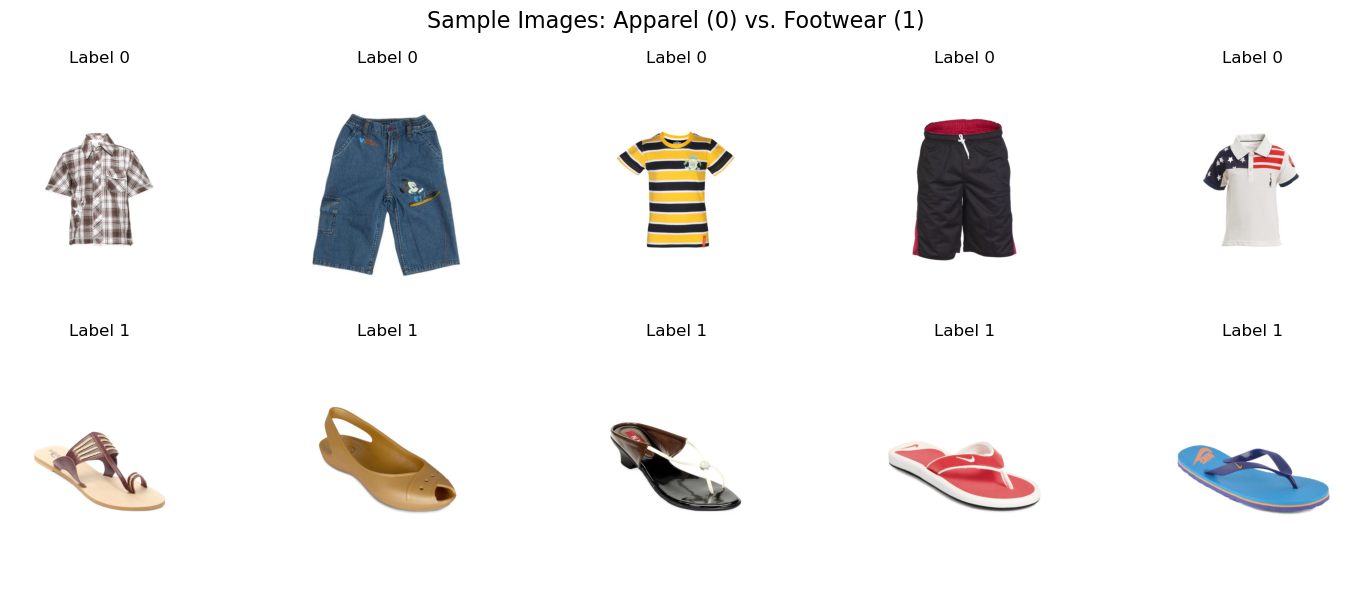

In [ ]:
def sample_images(folders, label, max_per_label=5):
    image_paths = []
    for folder in folders:
        files = [f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        sample_size = min(max_per_label - len(image_paths), len(files))
        image_paths += [(os.path.join(folder, f), label) for f in random.sample(files, sample_size)]
        if len(image_paths) >= max_per_label:
            break
    return image_paths

# Sample 5 each
apparel_samples = sample_images(apparel_dirs, 0, 5)
footwear_samples = sample_images(footwear_dirs, 1, 5)
image_samples = apparel_samples + footwear_samples

# Plot samples
plt.figure(figsize=(15, 6))
for i, (path, label) in enumerate(image_samples):
    try:
        img = Image.open(path)
        print(f"Image {i+1} (Label {label}): {img.size} - {os.path.basename(path)}")
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Label {label}')
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {path}: {e}")

plt.suptitle("Sample Images: Apparel (0) vs. Footwear (1)", fontsize=16)
plt.tight_layout()
plt.show()

### 3.4 Num of images in training, validation and test set

In [ ]:
print(f"Number of images loaded in training set: {len(X_train_imgs)}")
print(f"Number of images loaded in cross-validation set: {len(X_cv_imgs)}")
print(f"Number of images loaded in test set: {len(X_test_imgs)}")

Number of images loaded in training set: 1743
Number of images loaded in cross-validation set: 581
Number of images loaded in test set: 582


# 4. Base Model

## 4.1. Logistic Regression Model with No Hidden Layer

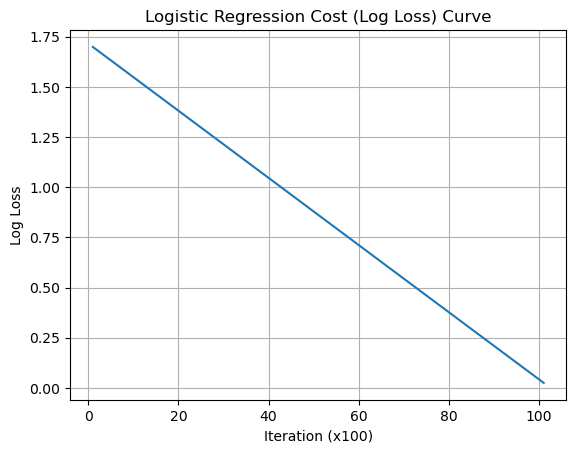

Logistic Regression - Training set accuracy: 0.9971313826735514
Logistic Regression - Cross-validation set accuracy: 0.9931153184165232


In [ ]:
from sklearn.neural_network import MLPClassifier

# Prepare data
X_train_lr = X_train_flat.T
X_cv_lr = X_cv_flat.T

# Logistic regression using MLPClassifier (no hidden layers)
logreg_mlp = MLPClassifier(hidden_layer_sizes=(), activation='logistic', solver='adam',
                           learning_rate_init=0.001, max_iter=2000, random_state=42, verbose=False)
logreg_mlp.fit(X_train_lr, Y_train.ravel())

# Plot cost (loss) every 100 iterations
loss_curve = logreg_mlp.loss_curve_
plt.plot(np.arange(1, len(loss_curve) + 1)[::100], loss_curve[::100])
plt.xlabel('Iteration (x100)')
plt.ylabel('Log Loss')
plt.title('Logistic Regression Cost (Log Loss) Curve')
plt.grid(True)
plt.show()

# Accuracy
print("Logistic Regression - Training set accuracy:", logreg_mlp.score(X_train_lr, Y_train.ravel()))
print("Logistic Regression - Cross-validation set accuracy:", logreg_mlp.score(X_cv_lr, Y_cv.ravel()))

## 4.2. A Neural Network with One Hidden Layer.

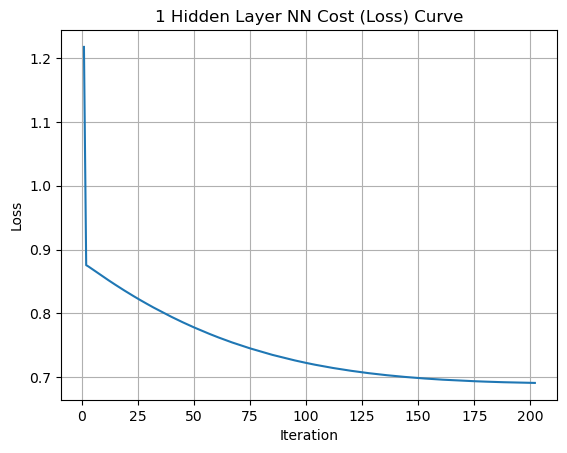

1 Hidden Layer NN - Training set accuracy: 0.5438898450946644
1 Hidden Layer NN - Cross-validation set accuracy: 0.5438898450946644


In [ ]:
from sklearn.neural_network import MLPClassifier

# Train MLP with 1 hidden layer of 4 units, ReLU activation
mlp = MLPClassifier(hidden_layer_sizes=(4,), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=2000, random_state=42, verbose=False)
mlp.fit(X_train_lr, Y_train.ravel())

# Plot cost (loss) every 100 iterations
plt.plot(np.arange(1, len(mlp.loss_curve_) + 1), mlp.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('1 Hidden Layer NN Cost (Loss) Curve')
plt.grid(True)
plt.show()

# Accuracy
print("1 Hidden Layer NN - Training set accuracy:", mlp.score(X_train_lr, Y_train.ravel()))
print("1 Hidden Layer NN - Cross-validation set accuracy:", mlp.score(X_cv_lr, Y_cv.ravel()))

## 4.3. A Neural Network with Two Hidden Layers.

### Define Network Architecture

In [ ]:
layers_dims = [X_train_flat.shape[0], 7, 4, 1]  # Input -> 7 -> 4 -> 1

In [ ]:
def nn_2l_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=2500, print_cost=True):
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(1, num_iterations + 1):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.4f}")

    # Plot the cost graph
    plt.plot(np.arange(100, num_iterations+1, 100), costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (per 100)')
    plt.title("2 Hidden Layer NN Cost (Loss) Curve")
    plt.grid(True)
    plt.show()

    return parameters

### Train & Evaluate the Model

Cost after iteration 100: 0.5433
Cost after iteration 200: 0.3866
Cost after iteration 300: 0.3096
Cost after iteration 400: 0.2651
Cost after iteration 500: 0.2301
Cost after iteration 600: 0.2044
Cost after iteration 700: 0.1837
Cost after iteration 800: 0.1666
Cost after iteration 900: 0.1524
Cost after iteration 1000: 0.1403
Cost after iteration 1100: 0.1300
Cost after iteration 1200: 0.1208
Cost after iteration 1300: 0.1129
Cost after iteration 1400: 0.1060
Cost after iteration 1500: 0.0999
Cost after iteration 1600: 0.0944
Cost after iteration 1700: 0.0895
Cost after iteration 1800: 0.0850
Cost after iteration 1900: 0.0809
Cost after iteration 2000: 0.0771


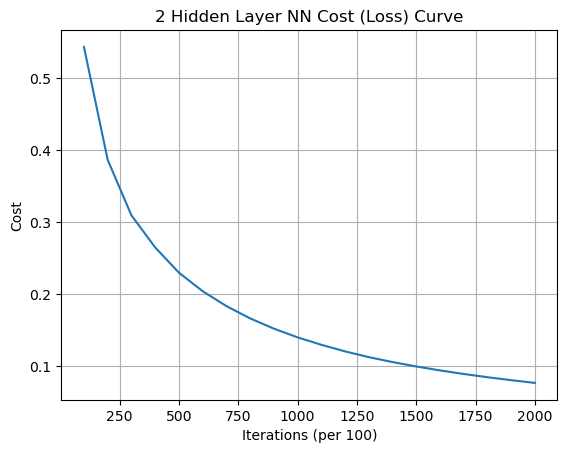

In [ ]:
parameters = nn_2l_model(X_train_flat, Y_train, layers_dims, learning_rate=0.01, num_iterations=2000)

In [ ]:
# performance accuracy on the training set
print("Train set:")
train_pred = predict(X_train_flat, Y_train, parameters)

Train set:
Accuracy: 0.9948364888123923


In [ ]:
# performance accuracy on the cross-validation set
print("Cross-validation set:")
cross_pred = predict(X_cv_flat, Y_cv, parameters)

Cross-validation set:
Accuracy: 1.0


In [ ]:
# performance accuracy on the test set
# Flatten and normalize test set
X_test_flat = X_test_imgs.reshape(X_test_imgs.shape[0], -1).T
Y_test = y_test.reshape(1, -1)

# Final performance on test set
print("Test set:")
test_pred = predict(X_test_flat, Y_test, parameters)

Test set:
Accuracy: 0.998281786941581


# 5. Other models

### 5.1 Best learning rate

In [ ]:
layers_dims = [X_train_flat.shape[0], 7, 4, 1]  # Input -> 7 -> 4 -> 1

In [ ]:
# Define the base model (neural network with 2 hiden layers)
def nn_2l_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=2500, print_cost=True):
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(1, num_iterations + 1):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.4f}")
    return parameters

In [ ]:
# Step 1: Generate 5 random alpha values (log scale)
alpha_values = [10 ** np.random.uniform(-3, 0) for _ in range(5)]

# Step 2: Generate 5 random n[1] values (uniform scale)
n_h1_values = [np.random.randint(2, 50) for _ in range(5)]

# Step 3: Grid search over all combinations
results = []

for alpha in alpha_values:
    for n_h1 in n_h1_values:
        layers_dims = [X_train_flat.shape[0], n_h1, 4, 1]

        parameters = nn_2l_model(X_train_flat, Y_train, layers_dims,
                                 learning_rate=alpha,
                                 num_iterations=2500,
                                 print_cost=False)

        # Predict on CV set
        AL_cv, _ = L_model_forward(X_cv_flat, parameters)
        predictions_cv = (AL_cv > 0.5).astype(int)
        accuracy_cv = 100 - np.mean(np.abs(predictions_cv - Y_cv)) * 100

        results.append({
            'alpha': alpha,
            'n_h1': n_h1,
            'cv_accuracy': accuracy_cv
        })

# Convert to DataFrame and sort by accuracy
results_df = pd.DataFrame(results).sort_values(by='cv_accuracy', ascending=False)

# Print full results
print("\nAll combinations sorted by cross-validation accuracy:")
print(results_df.to_string(index=False))

# Print best result
best = results_df.iloc[0]
print("\nBest Model from Randomized Grid Search:")
print(f"Alpha (learning rate): {best['alpha']:.5f}")
print(f"n[1] (hidden units): {best['n_h1']}")
print(f"CV Accuracy: {best['cv_accuracy']:.2f}%")

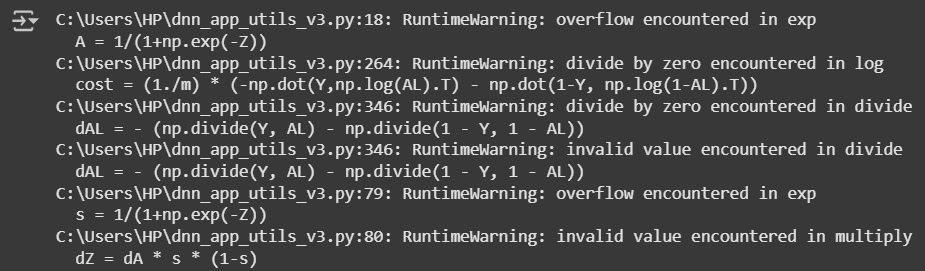
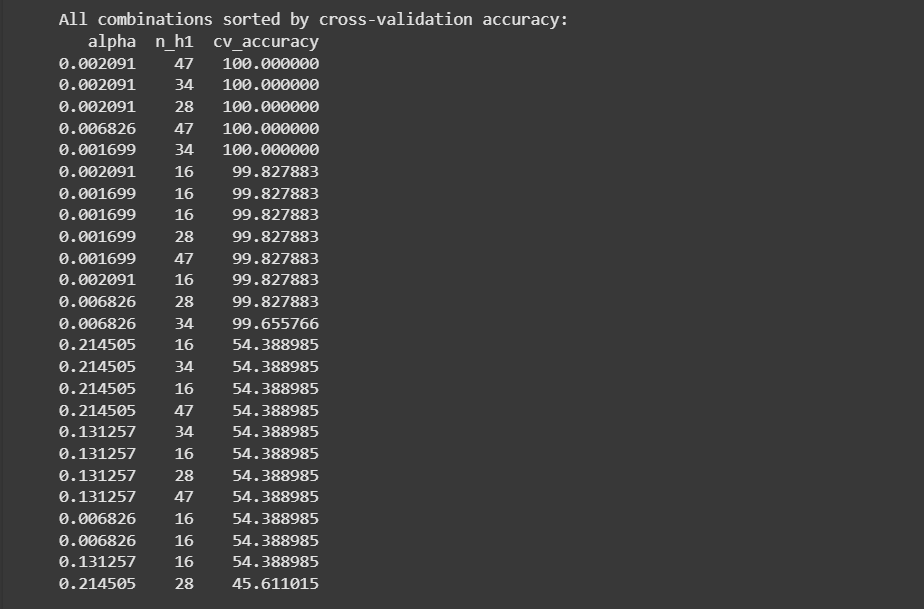
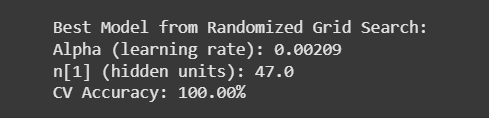

In [ ]:
results_grid_df = pd.DataFrame(results)
results_grid_df

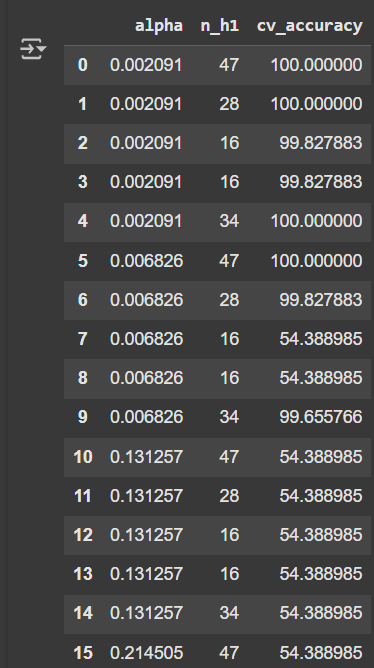

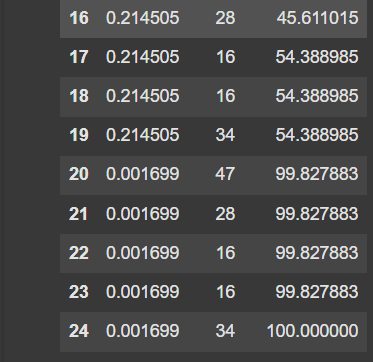

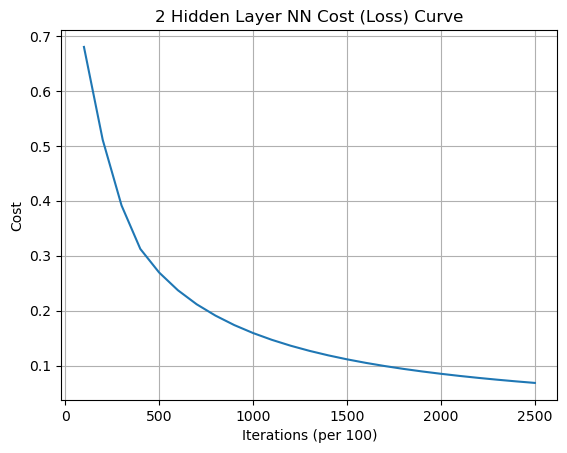

In [ ]:
# Use the best alpha and n for the training model
layers_dims = [X_train_flat.shape[0], 30, 4, 1]
parameters = nn_2l_model(X_train_flat, Y_train, layers_dims,
                                 learning_rate=0.00899,
                                 num_iterations=2500,
                                 print_cost=False)

In [ ]:
# performance accuracy on the training set
print("Train set:")
train_pred = predict(X_train_flat, Y_train, parameters)

Train set:
Accuracy: 0.9959839357429717


In [ ]:
# performance accuracy on the cross-validation set
print("Cross-validation set:")
cross_pred = predict(X_cv_flat, Y_cv, parameters)

Cross-validation set:
Accuracy: 0.9982788296041308


### 5.2 Best optimization algorithm

1. Mini Batch Gradient Descent

In [ ]:
# Using Mini-batch Gradient Descent (SGD)
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=0.001)

# Compile the model with SGD
model_sgd = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_sgd.compile(
    optimizer=optimizer_sgd,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history_sgd = model_sgd.fit(
    X_train_flat, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=2
)

# Evaluate the model on the training set with Mini-batch SGD
train_loss_sgd, train_accuracy_sgd = model_sgd.evaluate(X_train_flat, y_train)
print(f"\nMini-batch SGD Optimizer - Train Accuracy: {train_accuracy_sgd:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
28/28 - 1s - 49ms/step - binary_accuracy: 0.7435 - loss: 0.6618 - val_binary_accuracy: 0.5439 - val_loss: 0.7045
Epoch 2/10
28/28 - 1s - 32ms/step - binary_accuracy: 0.7912 - loss: 0.5608 - val_binary_accuracy: 0.5645 - val_loss: 0.7591
Epoch 3/10
28/28 - 1s - 25ms/step - binary_accuracy: 0.9380 - loss: 0.4482 - val_binary_accuracy: 0.7642 - val_loss: 0.4728
Epoch 4/10
28/28 - 1s - 18ms/step - binary_accuracy: 0.9421 - loss: 0.4022 - val_binary_accuracy: 0.9845 - val_loss: 0.3690
Epoch 5/10
28/28 - 0s - 16ms/step - binary_accuracy: 0.9535 - loss: 0.3694 - val_binary_accuracy: 0.9208 - val_loss: 0.3715
Epoch 6/10
28/28 - 1s - 19ms/step - binary_accuracy: 0.9707 - loss: 0.3291 - val_binary_accuracy: 0.9449 - val_loss: 0.3437
Epoch 7/10
28/28 - 1s - 21ms/step - binary_accuracy: 0.9730 - loss: 0.3083 - val_binary_accuracy: 0.9897 - val_loss: 0.2888
Epoch 8/10
28/28 - 1s - 20ms/step - binary_accuracy: 0.9765 - loss: 0.2870 - val_binary_accuracy: 0.9880 - val_loss: 0.2729
Epoch 9/

2. Momentum

In [ ]:
# Using Gradient Descent with Momentum
optimizer_sgd_momentum = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

# Compile the model with SGD with Momentum
model_sgd_momentum = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_sgd_momentum.compile(
    optimizer=optimizer_sgd_momentum,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model with SGD with Momentum (using a smaller batch size)
history_sgd_momentum = model_sgd_momentum.fit(
    X_train_flat, y_train,
    epochs=10, # Use the same number of epochs for comparison
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=2
)

# Evaluate the model on the training set with SGD with Momentum
train_loss_sgd_momentum, train_accuracy_sgd_momentum = model_sgd_momentum.evaluate(X_train_flat, y_train)
print(f"\nSGD with Momentum Optimizer - Train Accuracy: {train_accuracy_sgd_momentum:.4f}")

Epoch 1/10
28/28 - 2s - 54ms/step - binary_accuracy: 0.6867 - loss: 0.7012 - val_binary_accuracy: 0.7022 - val_loss: 0.5892
Epoch 2/10
28/28 - 0s - 14ms/step - binary_accuracy: 0.9237 - loss: 0.5229 - val_binary_accuracy: 0.8761 - val_loss: 0.4971
Epoch 3/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.9656 - loss: 0.4303 - val_binary_accuracy: 0.9673 - val_loss: 0.3854
Epoch 4/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.9730 - loss: 0.3475 - val_binary_accuracy: 0.9862 - val_loss: 0.3120
Epoch 5/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.9834 - loss: 0.2925 - val_binary_accuracy: 0.9587 - val_loss: 0.2919
Epoch 6/10
28/28 - 0s - 17ms/step - binary_accuracy: 0.9822 - loss: 0.2624 - val_binary_accuracy: 0.9862 - val_loss: 0.2377
Epoch 7/10
28/28 - 1s - 19ms/step - binary_accuracy: 0.9851 - loss: 0.2335 - val_binary_accuracy: 0.9552 - val_loss: 0.2562
Epoch 8/10
28/28 - 0s - 14ms/step - binary_accuracy: 0.9839 - loss: 0.2158 - val_binary_accuracy: 0.9845 - val_loss: 0.2183
Epoch 9/

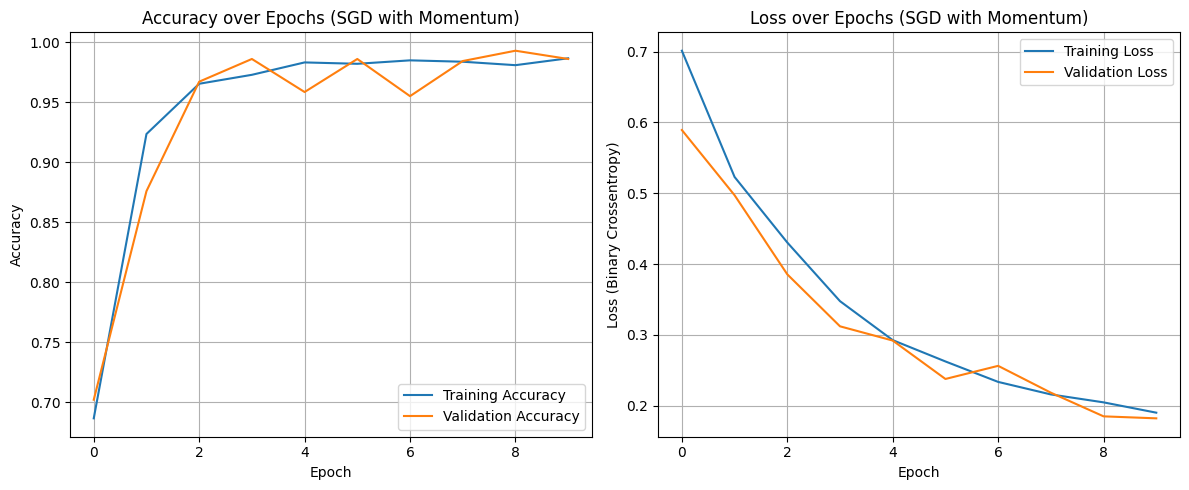

In [ ]:
# Extract training history
history = history_sgd_momentum

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (SGD with Momentum)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (SGD with Momentum)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on training set
train_loss_sgd_momentum, train_accuracy_sgd_momentum = model_sgd_momentum.evaluate(X_train_flat, y_train)
print(f"\nSGD with Momentum Optimizer - Train Accuracy: {train_accuracy_sgd_momentum:.4f}")

# Evaluate on validation set
val_loss_sgd_momentum, val_accuracy_sgd_momentum = model_sgd_momentum.evaluate(X_cv_flat, y_cv)
print(f"SGD with Momentum Optimizer - Validation Accuracy: {val_accuracy_sgd_momentum:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9837 - loss: 0.1960

SGD with Momentum Optimizer - Train Accuracy: 0.9868
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9846 - loss: 0.1799
SGD with Momentum Optimizer - Validation Accuracy: 0.9862


3. RMSprop

In [ ]:
# Using RMSprop optimizer
optimizer_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.95)

# Compile the model with RMSprop
model_rmsprop = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_rmsprop.compile(
    optimizer=optimizer_rmsprop,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model with RMSprop
history_rmsprop = model_rmsprop.fit(
    X_train_flat, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=2
)

# Evaluate the model on the training set with RMSprop
train_loss_rmsprop, train_accuracy_rmsprop = model_rmsprop.evaluate(X_train_flat, y_train)
print(f"\nRMSprop Optimizer - Train Accuracy: {train_accuracy_rmsprop:.4f}")

Epoch 1/10
28/28 - 2s - 84ms/step - binary_accuracy: 0.4739 - loss: 1.4100 - val_binary_accuracy: 0.5439 - val_loss: 0.7625
Epoch 2/10
28/28 - 1s - 26ms/step - binary_accuracy: 0.5439 - loss: 0.7596 - val_binary_accuracy: 0.5439 - val_loss: 0.7561
Epoch 3/10
28/28 - 1s - 19ms/step - binary_accuracy: 0.5439 - loss: 0.7530 - val_binary_accuracy: 0.5439 - val_loss: 0.7492
Epoch 4/10
28/28 - 0s - 14ms/step - binary_accuracy: 0.5439 - loss: 0.7457 - val_binary_accuracy: 0.5439 - val_loss: 0.7416
Epoch 5/10
28/28 - 0s - 16ms/step - binary_accuracy: 0.5439 - loss: 0.7376 - val_binary_accuracy: 0.5439 - val_loss: 0.7330
Epoch 6/10
28/28 - 0s - 15ms/step - binary_accuracy: 0.5439 - loss: 0.7289 - val_binary_accuracy: 0.5439 - val_loss: 0.7242
Epoch 7/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.5439 - loss: 0.7203 - val_binary_accuracy: 0.5439 - val_loss: 0.7160
Epoch 8/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.5439 - loss: 0.7127 - val_binary_accuracy: 0.5439 - val_loss: 0.7091
Epoch 9/

4. Adam

In [ ]:
# model built
model_adam = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])

# Match optimizer and learning rate from HW3
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001,
                      beta_1=0.90,
                      beta_2=0.99,
                      )

# Compile the model
model_adam.compile(
    optimizer=optimizer_adam,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

model_adam.fit(
    X_train_flat, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=2  # change to 2 if you'd like to see progress
)

# Evaluate the model on the training set with adam
train_loss_adam, train_accuracy_adam = model_adam.evaluate(X_train_flat, y_train)
print(f"\nAdam Optimizer - Train Accuracy: {train_accuracy_adam:.4f}")

Epoch 1/10
28/28 - 3s - 97ms/step - binary_accuracy: 0.4957 - loss: 0.8106 - val_binary_accuracy: 0.5439 - val_loss: 0.7549
Epoch 2/10
28/28 - 0s - 15ms/step - binary_accuracy: 0.5439 - loss: 0.7543 - val_binary_accuracy: 0.5439 - val_loss: 0.7531
Epoch 3/10
28/28 - 0s - 16ms/step - binary_accuracy: 0.5439 - loss: 0.7519 - val_binary_accuracy: 0.5439 - val_loss: 0.7502
Epoch 4/10
28/28 - 0s - 15ms/step - binary_accuracy: 0.5439 - loss: 0.7489 - val_binary_accuracy: 0.5439 - val_loss: 0.7473
Epoch 5/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.5439 - loss: 0.7458 - val_binary_accuracy: 0.5439 - val_loss: 0.7442
Epoch 6/10
28/28 - 1s - 21ms/step - binary_accuracy: 0.5439 - loss: 0.7428 - val_binary_accuracy: 0.5439 - val_loss: 0.7413
Epoch 7/10
28/28 - 0s - 15ms/step - binary_accuracy: 0.5439 - loss: 0.7399 - val_binary_accuracy: 0.5439 - val_loss: 0.7384
Epoch 8/10
28/28 - 1s - 22ms/step - binary_accuracy: 0.5439 - loss: 0.7370 - val_binary_accuracy: 0.5439 - val_loss: 0.7355
Epoch 9/

5. Report Training Performance in Table

In [ ]:
# Create a dictionary to store the results
performance_data = {
    'Optimizer': ['Adam', 'SGD', 'Momentum', 'RMSprop'],
    'Train Loss': [train_loss_adam, train_loss_sgd, train_loss_sgd_momentum, train_loss_rmsprop],
    'Train Accuracy': [train_accuracy_adam, train_accuracy_sgd, train_accuracy_sgd_momentum, train_accuracy_rmsprop]
}

# Create a pandas DataFrame from the dictionary
performance_df = pd.DataFrame(performance_data)

# Display the DataFrame
display(performance_df)

,Optimizer,Train Loss,Train Accuracy
0,Adam,0.729587,0.543890
1,SGD,0.268450,0.970166
2,Momentum,0.189582,0.986804
3,RMSprop,0.700199,0.543890


### 5.3 Best epochs

1. Epochs = 50

In [ ]:
# Using Gradient Descent with Momentum
optimizer_sgd_momentum50 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

# Compile the model with SGD with Momentum
model_sgd_momentum50 = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_sgd_momentum50.compile(
    optimizer=optimizer_sgd_momentum50,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model with SGD with Momentum (using a smaller batch size)
history_sgd_momentum50 = model_sgd_momentum50.fit(
    X_train_flat, y_train,
    epochs=50, # Use the same number of epochs for comparison
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=0
)

# Evaluate the model on the training set with SGD with Momentum
train_loss_sgd_momentum50, train_accuracy_sgd_momentum50 = model_sgd_momentum50.evaluate(X_train_flat, y_train)
print(f"\nSGD with Momentum Optimizer - Train Accuracy: {train_accuracy_sgd_momentum50:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5432 - loss: 0.7574

SGD with Momentum Optimizer - Train Accuracy: 0.5439


2. Epochs = 100

In [ ]:
# Using Gradient Descent with Momentum
optimizer_sgd_momentum100 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

# Compile the model with SGD with Momentum
model_sgd_momentum100 = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_sgd_momentum100.compile(
    optimizer=optimizer_sgd_momentum100,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model with SGD with Momentum (using a smaller batch size)
history_sgd_momentum100 = model_sgd_momentum100.fit(
    X_train_flat, y_train,
    epochs=100, # Use the same number of epochs for comparison
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=0
)

# Evaluate the model on the training set with SGD with Momentum
train_loss_sgd_momentum100, train_accuracy_sgd_momentum100 = model_sgd_momentum100.evaluate(X_train_flat, y_train)
print(f"\nSGD with Momentum Optimizer - Train Accuracy: {train_accuracy_sgd_momentum100:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9884 - loss: 0.2501

SGD with Momentum Optimizer - Train Accuracy: 0.9914


3. Epochs = 200

In [ ]:
# Using Gradient Descent with Momentum
optimizer_sgd_momentum200 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

# Compile the model with SGD with Momentum
model_sgd_momentum200 = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_sgd_momentum200.compile(
    optimizer=optimizer_sgd_momentum200,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model with SGD with Momentum (using a smaller batch size)
history_sgd_momentum200 = model_sgd_momentum200.fit(
    X_train_flat, y_train,
    epochs=200, # Use the same number of epochs for comparison
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=0
)

# Evaluate the model on the training set with SGD with Momentum
train_loss_sgd_momentum200, train_accuracy_sgd_momentum200 = model_sgd_momentum200.evaluate(X_train_flat, y_train)
print(f"\nSGD with Momentum Optimizer - Train Accuracy: {train_accuracy_sgd_momentum200:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9962 - loss: 0.1850

SGD with Momentum Optimizer - Train Accuracy: 0.9960


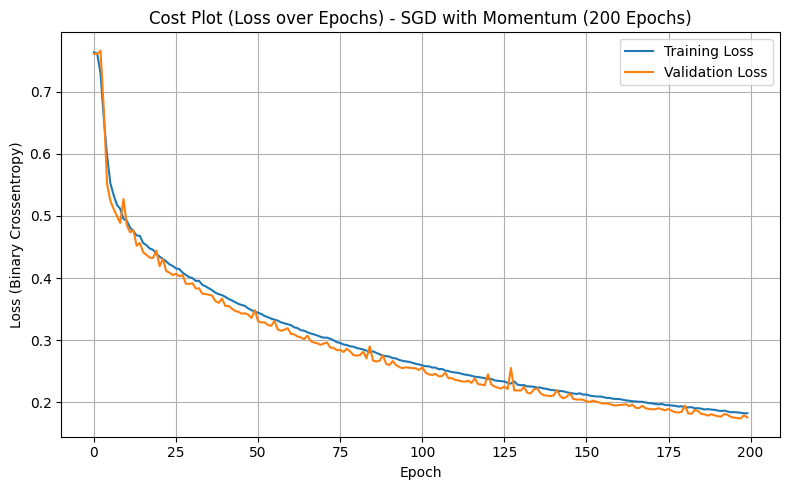

In [ ]:
# Extract training history
history = history_sgd_momentum200

# Plot Cost (Loss) over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Cost Plot (Loss over Epochs) - SGD with Momentum (200 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on training set
train_loss_sgd_momentum200, train_accuracy_sgd_momentum200 = model_sgd_momentum200.evaluate(X_train_flat, y_train)
print(f"\n200 Epochs with momentum Optimizer - Train Accuracy: {train_accuracy_sgd_momentum200:.4f}")

# Evaluate on validation set
val_loss_sgd_momentum200, val_accuracy_sgd_momentum200 = model_sgd_momentum200.evaluate(X_cv_flat, y_cv)
print(f"200 Epochs with Momentum Optimizer - Validation Accuracy: {val_accuracy_sgd_momentum200:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9962 - loss: 0.1850

200 Epochs with momentum Optimizer - Train Accuracy: 0.9960
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9967 - loss: 0.1739
200 Epochs with Momentum Optimizer - Validation Accuracy: 0.9983


4. Report a table

In [ ]:
# Create a dictionary to store the results
performance_data = {
    'Epochs': [50, 100, 200],
    'Train Loss': [train_loss_sgd_momentum50, train_loss_sgd_momentum100, train_loss_sgd_momentum200],
    'Train Accuracy': [train_accuracy_sgd_momentum50, train_accuracy_sgd_momentum100, train_accuracy_sgd_momentum200]
}

# Create a pandas DataFrame from the dictionary
performance_df = pd.DataFrame(performance_data)

# Display the DataFrame
display(performance_df)

,Epochs,Train Loss,Train Accuracy
0,50,0.757383,0.543890
1,100,0.248084,0.991394
2,200,0.181778,0.995984


### 5.4. Best weight initialization

In [ ]:
# Define model with variable weight initializer
def build_model(initializer):
    model = Sequential([
        Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
              kernel_initializer=initializer),  # First hidden layer
        Dense(4, activation='relu', kernel_initializer=initializer),  # Second hidden layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    # Compile with SGD optimizer and binary crossentropy loss
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

In [ ]:
# Set optimizer and loss function (from 5.2)
optimizer = SGD(learning_rate=0.001, momentum=0.5)
loss_fn = BinaryCrossentropy()
metrics = [BinaryAccuracy()]

In [ ]:
# Define initializers to test
initializers_dict = {
    "TF Default": None,  # No initializer passed (Keras default)
    "He Normal": HeNormal(),
    "Random Normal (stddev=0.05)": RandomNormal(stddev=0.05),
    "He Uniform": HeUniform()
}

# Store evaluation results
result = []

In [ ]:
# Create a table for performance of each weight initialization
performance_data = {
    'Initialization': [],
    'Train Accuracy': [],
    'Validation Accuracy': []
}

# Loop through initializers
for name, init in initializers_dict.items():
    print(f"\n=== Training with {name} ===")

    model = build_model(init if not isinstance(init, str) else None)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])

    history = model.fit(X_train_flat, y_train, epochs=200, batch_size=64,
                        validation_data=(X_cv_flat, y_cv), verbose=0)

    train_loss, train_acc = model.evaluate(X_train_flat, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_cv_flat, y_cv, verbose=0)

    # Append to dictionary
    performance_data['Initialization'].append(name)
    performance_data['Train Accuracy'].append(round(train_acc, 4))
    performance_data['Validation Accuracy'].append(round(val_acc, 4))

    print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")


=== Training with TF Default ===
Training Accuracy: 0.9920, Validation Accuracy: 0.9983

=== Training with He Normal ===
Training Accuracy: 0.9943, Validation Accuracy: 1.0000

=== Training with Random Normal (stddev=0.05) ===
Training Accuracy: 0.9908, Validation Accuracy: 1.0000

=== Training with He Uniform ===
Training Accuracy: 0.9925, Validation Accuracy: 1.0000


In [ ]:
# Create DataFrame
performance_df = pd.DataFrame(performance_data)

# Display table
display(performance_df)

,Initialization,Train Accuracy,Validation Accuracy
0,TF Default,0.9920,0.9983
1,He Normal,0.9943,1.0000
2,Random Normal (stddev=0.05),0.9908,1.0000
3,He Uniform,0.9925,1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


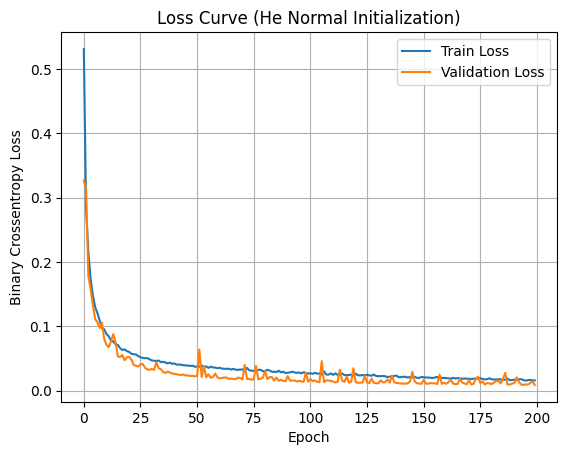

In [ ]:
# Retrain model with best initializer for cost plot (He Normal)
best_initializer = HeNormal()

model = build_model(best_initializer)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

history = model.fit(X_train_flat, y_train, epochs=200, batch_size=64,
                    validation_data=(X_cv_flat, y_cv), verbose=0)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (He Normal Initialization)')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

### 5.5 L2 regularization

In [ ]:
# Define Model with L2 Regularization
def build_model_l2(lambda_val):
    model = Sequential([
        Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
              kernel_regularizer=l2(lambda_val)),  # Default initializer
        Dense(4, activation='relu', kernel_regularizer=l2(lambda_val)),
        Dense(1, activation='sigmoid')  # No regularization on output
    ])
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model


In [ ]:
# Train & Evaluate for Each λ Value
lambda_values = [0, 0.001, 0.01, 0.1]  # L2 penalty (λ) values

performance_data_l2 = {
    'Lambda (L2 Penalty)': [],
    'Train Accuracy': [],
    'Validation Accuracy': []
}

loss_histories_l2 = {}  # to store loss curves

for lam in lambda_values:
    print(f"\n=== Training with λ = {lam} ===")
    model = build_model_l2(lambda_val=lam)

    history = model.fit(X_train_flat, y_train,
                        epochs=200,
                        batch_size=64,
                        validation_data=(X_cv_flat, y_cv),
                        verbose=0)

    train_loss, train_acc = model.evaluate(X_train_flat, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_cv_flat, y_cv, verbose=0)

    # Save performance
    performance_data_l2['Lambda (L2 Penalty)'].append(lam)
    performance_data_l2['Train Accuracy'].append(round(train_acc, 4))
    performance_data_l2['Validation Accuracy'].append(round(val_acc, 4))

    # Save loss curve
    loss_histories_l2[str(lam)] = history.history['loss']


=== Training with λ = 0 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Training with λ = 0.001 ===

=== Training with λ = 0.01 ===

=== Training with λ = 0.1 ===


In [ ]:
# Create a result table
performance_df_l2 = pd.DataFrame(performance_data_l2)
display(performance_df_l2)

,Lambda (L2 Penalty),Train Accuracy,Validation Accuracy
0,0.000,0.9937,0.9983
1,0.001,0.9925,0.9948
2,0.010,0.9931,1.0000
3,0.100,0.9862,0.9948


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


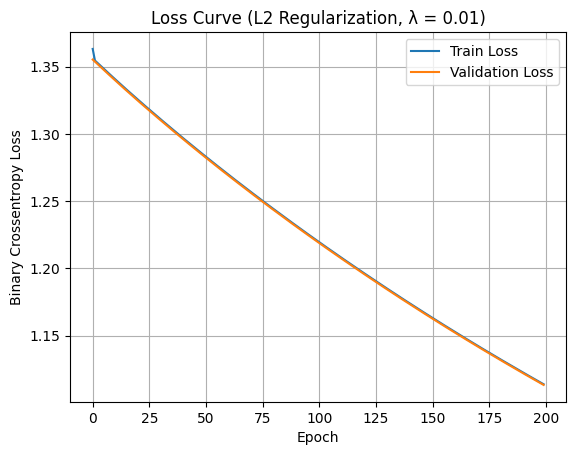

In [ ]:
# 1. Build model with best performing L2 = 0.01
def build_model_l2(lambda_val=0.01):
    model = Sequential([
        Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
              kernel_regularizer=l2(lambda_val)),  # Default initializer
        Dense(4, activation='relu', kernel_regularizer=l2(lambda_val)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

# 2. Train model
model = build_model_l2(0.01)
history = model.fit(X_train_flat, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_cv_flat, y_cv),
                    verbose=0)

# 3. Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (L2 Regularization, λ = 0.01)')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

### 5.6 Dropout regularization

In [ ]:
# Define model with dropout
def build_model_dropout(dropout_rate):
    model = Sequential([
        Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],)),  # No init change
        Dropout(dropout_rate),  # Dropout after first hidden layer
        Dense(4, activation='relu'),
        Dropout(dropout_rate),  # Dropout after second hidden layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

In [ ]:
# Train and evaluate each dropout rate
dropout_rates = [0.0, 0.2, 0.4, 0.6]

performance_data_dropout = {
    'Dropout Rate': [],
    'Train Accuracy': [],
    'Validation Accuracy': []
}

loss_histories_dropout = {}

for rate in dropout_rates:
    print(f"\n=== Training with Dropout Rate = {rate} ===")
    model = build_model_dropout(rate)

    history = model.fit(X_train_flat, y_train,
                        epochs=200,
                        batch_size=64,
                        validation_data=(X_cv_flat, y_cv),
                        verbose=0)

    train_loss, train_acc = model.evaluate(X_train_flat, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_cv_flat, y_cv, verbose=0)

    performance_data_dropout['Dropout Rate'].append(rate)
    performance_data_dropout['Train Accuracy'].append(round(train_acc, 4))
    performance_data_dropout['Validation Accuracy'].append(round(val_acc, 4))

    # Store loss curve (optional)
    loss_histories_dropout[str(rate)] = history.history['loss']


=== Training with Dropout Rate = 0.0 ===

=== Training with Dropout Rate = 0.2 ===

=== Training with Dropout Rate = 0.4 ===

=== Training with Dropout Rate = 0.6 ===


In [ ]:
# Create a result table
performance_df_dropout = pd.DataFrame(performance_data_dropout)
display(performance_df_dropout)

,Dropout Rate,Train Accuracy,Validation Accuracy
0,0.0,0.9960,0.9966
1,0.2,0.9925,1.0000
2,0.4,0.9954,0.9966
3,0.6,0.9925,1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


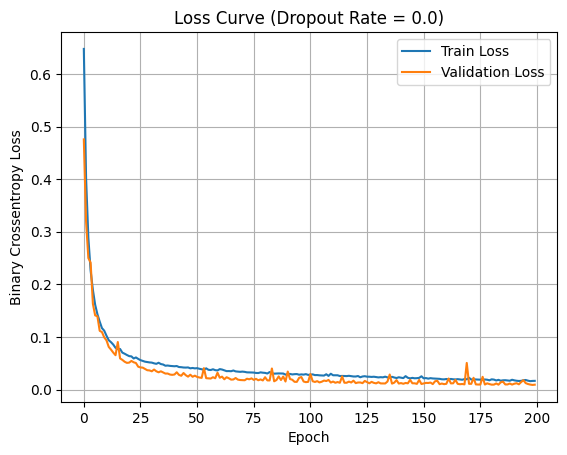

In [ ]:
# Re-train the model with best performing dropout = 0.0
model = build_model_dropout(dropout_rate=0.0)
history = model.fit(X_train_flat, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_cv_flat, y_cv),
                    verbose=0)

# Plot both losses from the same run
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (Dropout Rate = 0.0)')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

### 5.7 Dropout regularization & L2 regularization

In [ ]:
# Define Model: Dropout + L2 Regularization
def build_model_l2_dropout(lambda_val, dropout_rate):
    model = Sequential([
        Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
              kernel_regularizer=l2(lambda_val)),  # L2 regularization
        Dropout(dropout_rate),  # Dropout after first hidden layer
        Dense(4, activation='relu', kernel_regularizer=l2(lambda_val)),
        Dropout(dropout_rate),  # Dropout after second hidden layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

In [ ]:
# Define values to test
lambda_vals = [0.0, 0.01, 0.1]
dropout_rates = [0.0, 0.4, 0.6]

performance_data_combo = {
    'L2 λ': [],
    'Dropout Rate': [],
    'Train Accuracy': [],
    'Validation Accuracy': []
}

for lam in lambda_vals:
    for dr in dropout_rates:
        print(f"\n=== Training with λ = {lam}, Dropout = {dr} ===")
        model = build_model_l2_dropout(lambda_val=lam, dropout_rate=dr)

        history = model.fit(X_train_flat, y_train,
                            epochs=200,
                            batch_size=64,
                            validation_data=(X_cv_flat, y_cv),
                            verbose=0)

        train_loss, train_acc = model.evaluate(X_train_flat, y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_cv_flat, y_cv, verbose=0)

        performance_data_combo['L2 λ'].append(lam)
        performance_data_combo['Dropout Rate'].append(dr)
        performance_data_combo['Train Accuracy'].append(round(train_acc, 4))
        performance_data_combo['Validation Accuracy'].append(round(val_acc, 4))


=== Training with λ = 0.0, Dropout = 0.0 ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Training with λ = 0.0, Dropout = 0.4 ===

=== Training with λ = 0.0, Dropout = 0.6 ===

=== Training with λ = 0.01, Dropout = 0.0 ===

=== Training with λ = 0.01, Dropout = 0.4 ===

=== Training with λ = 0.01, Dropout = 0.6 ===

=== Training with λ = 0.1, Dropout = 0.0 ===

=== Training with λ = 0.1, Dropout = 0.4 ===

=== Training with λ = 0.1, Dropout = 0.6 ===


In [ ]:
# Create a result table
performance_df_combo = pd.DataFrame(performance_data_combo)
display(performance_df_combo)

,L2 λ,Dropout Rate,Train Accuracy,Validation Accuracy
0,0.00,0.0,0.9971,0.9983
1,0.00,0.4,0.9908,0.9966
2,0.00,0.6,0.9897,0.9914
3,0.01,0.0,0.9948,0.9966
4,0.01,0.4,0.9937,1.0000
5,0.01,0.6,0.9931,1.0000
6,0.10,0.0,0.9925,1.0000
7,0.10,0.4,0.9920,0.9983
8,0.10,0.6,0.9920,0.9966


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


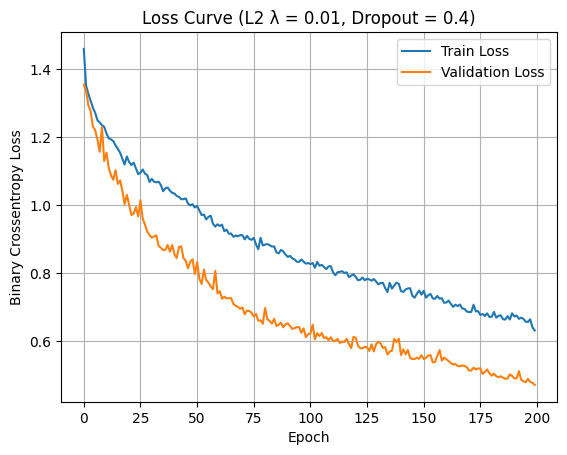

In [ ]:
# Re-train the model using the best performing combination (L2 = 0.01, dropout = 0.4)
model = build_model_l2_dropout(lambda_val=0.01, dropout_rate=0.4)
history = model.fit(X_train_flat, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_cv_flat, y_cv),
                    verbose=0)

# Plot cost (loss) curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (L2 λ = 0.01, Dropout = 0.4)')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

### 5.8 Batch-normalization

In [ ]:
# BN 1 (Default Batch Normalization)
from tensorflow.keras.layers import BatchNormalization

model_bn1 = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),  # Default
    Dense(4, activation='relu', kernel_initializer=initializers.HeNormal()),
    BatchNormalization(),  # Default
    Dense(1, activation='sigmoid')
])

model_bn1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])

history_bn1 = model_bn1.fit(
    X_train_flat, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=0
)

train_loss_bn1, train_acc_bn1 = model_bn1.evaluate(X_train_flat, y_train, verbose=0)
val_loss_bn1, val_acc_bn1 = model_bn1.evaluate(X_cv_flat, y_cv, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# BN 2 (Custom Batch Normalization)
model_bn2 = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal()),
    BatchNormalization(momentum=0.9, epsilon=1e-4),
    Dense(4, activation='relu', kernel_initializer=initializers.HeNormal()),
    BatchNormalization(momentum=0.9, epsilon=1e-4),
    Dense(1, activation='sigmoid')
])

model_bn2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])

history_bn2 = model_bn2.fit(
    X_train_flat, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    verbose=0
)

train_loss_bn2, train_acc_bn2 = model_bn2.evaluate(X_train_flat, y_train, verbose=0)
val_loss_bn2, val_acc_bn2 = model_bn2.evaluate(X_cv_flat, y_cv, verbose=0)

In [ ]:
# -------- Display the results --------
print("\n--- Batch Normalization Comparison ---")
print(f"No BN (from 5.3):\t\tTrain Acc = 0.9960\tVal Acc = 0.9983")  # Adjust from 5.3 results
print(f"BN 1 (Default):\t\tTrain Acc = {train_acc_bn1:.4f}\tVal Acc = {val_acc_bn1:.4f}")
print(f"BN 2 (Custom):\t\tTrain Acc = {train_acc_bn2:.4f}\tVal Acc = {val_acc_bn2:.4f}")


--- Batch Normalization Comparison ---
No BN (from 5.3):		Train Acc = 0.9960	Val Acc = 0.9983
BN 1 (Default):		Train Acc = 0.9983	Val Acc = 0.9966
BN 2 (Custom):		Train Acc = 0.9994	Val Acc = 0.9983


### 5.9 Early Stopping

In [ ]:
# Implement Early Stopping

# Using Gradient Descent with Momentum
optimizer_sgd_momentum_early_stop = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

# Compile the model with SGD with Momentum
model_sgd_momentum_early_stop = Sequential([
    Dense(30, activation='relu', input_shape=(X_train_flat.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(4, activation='relu',
          kernel_initializer=initializers.HeNormal(),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])
model_sgd_momentum_early_stop.compile(
    optimizer=optimizer_sgd_momentum_early_stop,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Define the Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Stop after 10 epochs with no improvement
    restore_best_weights=True # Restore model weights from the epoch with the best monitored value
)

# Train the model with SGD with Momentum (using a smaller batch size)
history_sgd_momentum_early_stop = model_sgd_momentum_early_stop.fit(
    X_train_flat, y_train,
    epochs=200, # Use a higher number, Early Stopping will stop it sooner
    batch_size=64,
    validation_data=(X_cv_flat, y_cv),
    callbacks=[early_stopping], # Add the callback here
    verbose=0
)

# Evaluation
print("\n--- Early Stopping Comparison ---")
print(f"No BN (from 5.3):\t\tTrain Acc = 0.9960\tVal Acc = 0.9983")  # Adjust from 5.3 results

# Evaluate the model on the training set with SGD with Momentum
train_loss_sgd_momentum_early_stop, train_accuracy_sgd_momentum_early_stop = model_sgd_momentum_early_stop.evaluate(X_train_flat, y_train)
print(f"\nSGD with Momentum Optimizer and Early Stopping - Train Accuracy: {train_accuracy_sgd_momentum_early_stop:.4f}")

# Evaluate the model on the cross-validation set with SGD with Momentum
val_loss_sgd_momentum_early_stop, val_accuracy_sgd_momentum_early_stop = model_sgd_momentum_early_stop.evaluate(X_cv_flat, y_cv)
print(f"SGD with Momentum Optimizer and Early Stopping - Cross-validation Accuracy: {val_accuracy_sgd_momentum_early_stop:.4f}")


--- Early Stopping Comparison ---
No BN (from 5.3):		Train Acc = 0.9960	Val Acc = 0.9983
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9912 - loss: 0.0871

SGD with Momentum Optimizer and Early Stopping - Train Accuracy: 0.9931
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 1.0000 - loss: 0.0758
SGD with Momentum Optimizer and Early Stopping - Cross-validation Accuracy: 1.0000


### 5.10 CNN Model

In [ ]:
# Define CNN model for binary classification
cnn_model = Sequential([
    # Conv1
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),

    # Pool1
    MaxPooling2D(pool_size=(2, 2)),

    # Conv2
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

    # Pool2
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output
    Flatten(),

    # Fully connected (dense) layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Final output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Display model structure
cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,634,241 (6.23 MB)

 Trainable params: 1,633,857 (6.23 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
## Save the best weights for your CNN model during training
# Set checkpoint path
checkpoint_path = "cnn_best_model.weights.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    verbose=1
)

# Add early stopping for efficiency
early_stop = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Compile the model before training
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the CNN model with checkpoint callback
history = cnn_model.fit(
    X_train_imgs, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_cv_imgs, y_cv),
    callbacks=[checkpoint_callback, early_stop],
    verbose=0
)


Epoch 1: val_binary_accuracy improved from -inf to 0.45611, saving model to cnn_best_model.weights.h5

Epoch 2: val_binary_accuracy did not improve from 0.45611

Epoch 3: val_binary_accuracy did not improve from 0.45611

Epoch 4: val_binary_accuracy did not improve from 0.45611

Epoch 5: val_binary_accuracy improved from 0.45611 to 0.46988, saving model to cnn_best_model.weights.h5

Epoch 6: val_binary_accuracy improved from 0.46988 to 0.76076, saving model to cnn_best_model.weights.h5

Epoch 7: val_binary_accuracy improved from 0.76076 to 0.96902, saving model to cnn_best_model.weights.h5

Epoch 8: val_binary_accuracy did not improve from 0.96902

Epoch 9: val_binary_accuracy improved from 0.96902 to 0.97762, saving model to cnn_best_model.weights.h5

Epoch 10: val_binary_accuracy improved from 0.97762 to 0.99656, saving model to cnn_best_model.weights.h5

Epoch 11: val_binary_accuracy did not improve from 0.99656

Epoch 12: val_binary_accuracy did not improve from 0.99656

Epoch 13:

In [ ]:
cnn_model.load_weights("cnn_best_model.weights.h5")

# Inspect weights for the best CNN model
for layer in cnn_model.layers:
    weights = layer.get_weights()
    if weights:
        print(f"{layer.name} weights shape: {[w.shape for w in weights]}")

conv2d_2 weights shape: [(3, 3, 3, 32), (32,)]
conv2d_3 weights shape: [(3, 3, 32, 64), (64,)]
dense_18 weights shape: [(12544, 128), (128,)]
batch_normalization_6 weights shape: [(128,), (128,), (128,), (128,)]
dense_19 weights shape: [(128, 64), (64,)]
batch_normalization_7 weights shape: [(64,), (64,), (64,), (64,)]
dense_20 weights shape: [(64, 1), (1,)]


In [ ]:
# Evaluate the CNN model
train_loss_cnn, train_accuracy_cnn = cnn_model.evaluate(X_train_imgs, y_train, verbose=0)
val_loss_cnn, val_accuracy_cnn = cnn_model.evaluate(X_cv_imgs, y_cv, verbose=0)

print("\n--- CNN Model Evaluation ---")
print(f"Model from 5.3):\t\tTrain Acc = 0.9960\tVal Acc = 0.9983")  # Adjust from 5.3 results
print(f"Training Accuracy: {train_accuracy_cnn:.4f}")
print(f"Validation Accuracy: {val_accuracy_cnn:.4f}")


--- CNN Model Evaluation ---
Model from 5.3):		Train Acc = 0.9960	Val Acc = 0.9983
Training Accuracy: 0.9989
Validation Accuracy: 0.9966


### 5.11 Pre-trained Model

In [ ]:
# Choose pre-trained model: MobileNet
# Step 1: Import & Preprocess
# Resize images for MobileNetV2 (must be at least 96x96)
NEW_IMG_SIZE = (96, 96)

def resize_images(images, size=NEW_IMG_SIZE):
    return np.array([np.array(Image.fromarray(img).resize(size)) for img in images])

X_train_mnet = resize_images(X_train_imgs)
X_cv_mnet = resize_images(X_cv_imgs)
X_test_mnet = resize_images(X_test_imgs)

# Scale pixel values to [-1, 1] as MobileNet wants
X_train_mnet = (X_train_mnet / 127.5) - 1
X_cv_mnet = (X_cv_mnet / 127.5) - 1
X_test_mnet = (X_test_mnet / 127.5) - 1

In [ ]:
# Step 2: Load Pre-trained MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Load pre-trained model without the top layer (because we’ll make our own)
base_model = MobileNetV2(include_top=False, input_shape=(96, 96, 3), weights='imagenet')

# Freeze base model so its weights don’t change during training
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 3: Add Your Own Layers (the “Head”)
 # Add new layers on top
inputs = Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary output

mobilenet_model = Model(inputs, outputs)

In [ ]:
# Step 4: Compile and Train
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "mobilenet_best.weights.h5", save_best_only=True,
    monitor='val_binary_accuracy', mode='max', save_weights_only=True, verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', patience=5,
    restore_best_weights=True, verbose=1
)

# Train!
history = mobilenet_model.fit(
    X_train_mnet, y_train,
    validation_data=(X_cv_mnet, y_cv),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint, early_stop],
    verbose=2
)

Epoch 1/20

Epoch 1: val_binary_accuracy improved from -inf to 1.00000, saving model to mobilenet_best.weights.h5
28/28 - 27s - 972ms/step - binary_accuracy: 0.9564 - loss: 0.1080 - val_binary_accuracy: 1.0000 - val_loss: 0.0019
Epoch 2/20

Epoch 2: val_binary_accuracy did not improve from 1.00000
28/28 - 17s - 611ms/step - binary_accuracy: 0.9994 - loss: 0.0021 - val_binary_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/20

Epoch 3: val_binary_accuracy did not improve from 1.00000
28/28 - 19s - 680ms/step - binary_accuracy: 1.0000 - loss: 6.5477e-04 - val_binary_accuracy: 1.0000 - val_loss: 8.7307e-04
Epoch 4/20

Epoch 4: val_binary_accuracy did not improve from 1.00000
28/28 - 22s - 789ms/step - binary_accuracy: 1.0000 - loss: 8.4266e-04 - val_binary_accuracy: 1.0000 - val_loss: 2.3741e-04
Epoch 5/20

Epoch 5: val_binary_accuracy did not improve from 1.00000
28/28 - 20s - 731ms/step - binary_accuracy: 1.0000 - loss: 4.2814e-04 - val_binary_accuracy: 1.0000 - val_loss: 1.8461e-04
Epoch 6

In [ ]:
# Step 5: Evaluate and Compare the Trained Model
# Evaluate the trained pre-trained model on the training set
train_loss_mnet, train_accuracy_mnet = mobilenet_model.evaluate(X_train_mnet, y_train, verbose=0)

# Evaluate the trained pre-trained model on the cross-validation set
val_loss_mnet, val_accuracy_mnet = mobilenet_model.evaluate(X_cv_mnet, y_cv, verbose=0)

print("\n--- Pre-trained MobileNetV2 Model Evaluation ---")
print(f"Model from 5.3:\t\tTrain Acc = 0.9960\tVal Acc = 0.9983")
print(f"Training Accuracy: {train_accuracy_mnet:.4f}")
print(f"Validation Accuracy: {val_accuracy_mnet:.4f}")


--- Pre-trained MobileNetV2 Model Evaluation ---
Model from 5.3:		Train Acc = 0.9960	Val Acc = 0.9983
Training Accuracy: 0.9994
Validation Accuracy: 1.0000


### 5.12 RNN Model

In [ ]:
# Prepare data for RNNs
img_height, img_width, img_channels = X_train_imgs_n.shape[1], X_train_imgs_n.shape[2], X_train_imgs_n.shape[3]
X_train_rnn = X_train_imgs_n.reshape(-1, img_width, img_height * img_channels)
X_cv_rnn = X_cv_imgs_n.reshape(-1, img_width, img_height * img_channels)
X_test_rnn = X_test_imgs_n.reshape(-1, img_width, img_height * img_channels)

print(f"RNN Training data shape: {X_train_rnn.shape}")
print(f"RNN Validation data shape: {X_cv_rnn.shape}")
print(f"RNN Test data shape: {X_test_rnn.shape}")

RNN Training data shape: (1743, 64, 192)
RNN Validation data shape: (581, 64, 192)
RNN Test data shape: (582, 64, 192)


In [ ]:
# --- GRU Model ---
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, TimeDistributed

gru_model = Sequential([
    GRU(64, return_sequences=False, input_shape=(img_width, img_height * img_channels)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

gru_model.summary()

# Train GRU
print("\n--- Training GRU Model ---")
checkpoint_gru = tf.keras.callbacks.ModelCheckpoint(
    "gru_best.weights.h5", save_best_only=True,
    monitor='val_binary_accuracy', mode='max', save_weights_only=True, verbose=1
)

early_stop_gru = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', patience=5,
    restore_best_weights=True, verbose=0
)

history_gru = gru_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_cv_rnn, y_cv),
    epochs=50, # Reduced epochs
    batch_size=64,
    callbacks=[checkpoint_gru, early_stop_gru],
    verbose=0
)

# Load best weights and evaluate
gru_model.load_weights("gru_best.weights.h5")
train_loss_gru, train_accuracy_gru = gru_model.evaluate(X_train_rnn, y_train, verbose=0)
val_loss_gru, val_accuracy_gru = gru_model.evaluate(X_cv_rnn, y_cv, verbose=0)

print("\n--- GRU Model Evaluation ---")
print(f"Model from 5.3:\t\tTrain Acc = 0.9960\tVal Acc = 0.9983")
print(f"Training Accuracy: {train_accuracy_gru:.4f}")
print(f"Validation Accuracy: {val_accuracy_gru:.4f}")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        49,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,649 (201.75 KB)

 Trainable params: 51,649 (201.75 KB)

 Non-trainable params: 0 (0.00 B)


--- Training GRU Model ---

Epoch 1: val_binary_accuracy improved from -inf to 0.54389, saving model to gru_best.weights.h5

Epoch 2: val_binary_accuracy improved from 0.54389 to 0.90534, saving model to gru_best.weights.h5

Epoch 3: val_binary_accuracy improved from 0.90534 to 0.95697, saving model to gru_best.weights.h5

Epoch 4: val_binary_accuracy improved from 0.95697 to 0.98451, saving model to gru_best.weights.h5

Epoch 5: val_binary_accuracy improved from 0.98451 to 0.98623, saving model to gru_best.weights.h5

Epoch 6: val_binary_accuracy improved from 0.98623 to 0.99312, saving model to gru_best.weights.h5

Epoch 7: val_binary_accuracy did not improve from 0.99312

Epoch 8: val_binary_accuracy improved from 0.99312 to 0.99656, saving model to gru_best.weights.h5

Epoch 9: val_binary_accuracy did not improve from 0.99656

Epoch 10: val_binary_accuracy did not improve from 0.99656

Epoch 11: val_binary_accuracy did not improve from 0.99656

Epoch 12: val_binary_accuracy did no